## Load Libraries 

In [2]:
from math import sqrt
import pandas as pd
import torch
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Dataset


In [3]:
# Reading ratings file
ratings = pd.read_csv('ratings.csv', sep=',', encoding='latin-1', usecols=['userId','movieId','rating','timestamp'])

# Reading movies file
movies = pd.read_csv('movies.csv', sep=',', encoding='latin-1', usecols=['movieId','title','genres'])

In [4]:
df_movies = movies 
df_ratings = ratings 

#Exploring Data 

In [5]:
df_movies.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Most popular genres of movie released

<BarContainer object of 19 artists>

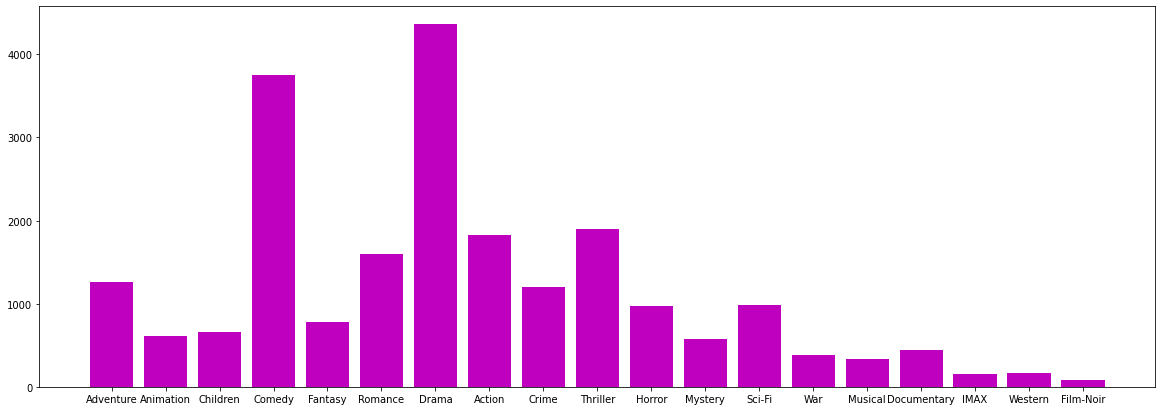

In [6]:
plt.figure(figsize=(20,7))
generlist = df_movies['genres'].apply(lambda generlist_movie : str(generlist_movie).split("|"))
geners_count = {}

for generlist_movie in generlist:
    for gener in generlist_movie:
        if(geners_count.get(gener,False)):
            geners_count[gener]=geners_count[gener]+1
        else:
            geners_count[gener] = 1       
geners_count.pop("(no genres listed)")
plt.bar(geners_count.keys(),geners_count.values(),color='m')

In [7]:
df_ratings.head(5)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


### Distribution of users rating

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


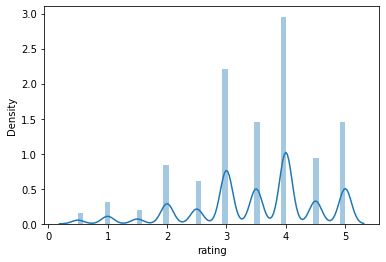

In [8]:
sns.distplot(df_ratings["rating"]);

In [9]:
print("Shape of frames: \n"+ " Rating DataFrame"+ str(df_ratings.shape)+"\n Movies DataFrame"+ str(df_movies.shape))

Shape of frames: 
 Rating DataFrame(100836, 4)
 Movies DataFrame(9742, 3)


In [10]:
merge_ratings_movies = pd.merge(df_movies, df_ratings, on='movieId', how='inner')

In [11]:
merge_ratings_movies.head(2)

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962


In [12]:
merge_ratings_movies = merge_ratings_movies.drop('timestamp', axis=1)

In [13]:
merge_ratings_movies.shape

(100836, 5)

Grouping the rating based on user

In [ ]:
ratings_grouped_by_users = merge_ratings_movies.groupby('userId').agg([np.size, np.mean])

In [ ]:
ratings_grouped_by_users.head(2)

movieId               rating          
          size          mean   size      mean
userId                                       
1          232   1854.603448    232  4.366379
2           29  70350.275862     29  3.948276

In [ ]:
ratings_grouped_by_users = ratings_grouped_by_users.drop('movieId', axis = 1)

### Top 10 users who have rated most of the movies

In [16]:
ratings_grouped_by_movies = merge_ratings_movies.groupby('movieId').agg([np.mean], np.size)

In [17]:
ratings_grouped_by_movies.shape

(9724, 2)

In [ ]:
ratings_grouped_by_movies.head(3)

,userId,rating
,mean,mean
movieId,,
1,306.530233,3.920930
2,329.554545,3.431818
3,283.596154,3.259615


In [18]:
ratings_grouped_by_movies = ratings_grouped_by_movies.drop('userId', axis=1)

# Content based filtering


.

#Cosine similarity#
**That means higher the value more similar they are. But as the function gives us the distance, we will deduct it from 1.**

Here We are  finding total type of geners by TfidVectorizer. then find similarity of movies by cossine similarity algorithm

In [25]:
# Define a TF-IDF Vectorizer Object.
tfidf_movies_genres = TfidfVectorizer(token_pattern = '[a-zA-Z0-9\-]+')

#Replace NaN with an empty string
df_movies['genres'] = df_movies['genres'].replace(to_replace="(no genres listed)", value="")

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_movies_genres_matrix = tfidf_movies_genres.fit_transform(df_movies['genres'])
print(tfidf_movies_genres.get_feature_names())
# Compute the cosine similarity matrix
print(tfidf_movies_genres_matrix.shape)
print(tfidf_movies_genres_matrix.dtype)
cosine_sim_movies = linear_kernel(tfidf_movies_genres_matrix, tfidf_movies_genres_matrix)
print(cosine_sim_movies)

['action', 'adventure', 'animation', 'children', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'film-noir', 'horror', 'imax', 'musical', 'mystery', 'romance', 'sci-fi', 'thriller', 'war', 'western']
(9742, 19)
float64
[[1.         0.81357774 0.15276924 ... 0.         0.4210373  0.26758648]
 [0.81357774 1.         0.         ... 0.         0.         0.        ]
 [0.15276924 0.         1.         ... 0.         0.         0.57091541]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.4210373  0.         0.         ... 0.         1.         0.        ]
 [0.26758648 0.         0.57091541 ... 0.         0.         1.        ]]


Here We are finding top 2 most recommend movies based on a particular movie. that is most similar movie when we give a input movie


    Calculates top 2 movies to recommend based on given movie titles genres. 
    :param movie_title: title of movie to be taken for base of recommendation
    :param cosine_sim_movies: cosine similarity between movies 
    :return: Titles of movies recommended to user
    

begnning of a program- to get most recommend movies based on a particular movie

In [27]:
def get_recommendations_based_on_genres(movie_title, cosine_sim_movies=cosine_sim_movies):
   
    # Get the index of the movie that matches the title
    idx_movie = df_movies.loc[df_movies['title'].isin([movie_title])]
    idx_movie = idx_movie.index
    
    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores_movies = list(enumerate(cosine_sim_movies[idx_movie][0]))
    
    # Sort the movies based on the similarity scores
    sim_scores_movies = sorted(sim_scores_movies, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores_movies = sim_scores_movies[1:3]
    
    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores_movies]
    
    # Return the top 2 most similar movies
    return df_movies['title'].iloc[movie_indices]


function call

In [ ]:
get_recommendations_based_on_genres("Father of the Bride Part II (1995)")

17                        Four Rooms (1995)
18    Ace Ventura: When Nature Calls (1995)
Name: title, dtype: object

This part is for recommending top movies to a user based on the watching history of user

    """
    Calculates top movies to be recommended to user based on movie user has watched.  
    :param userId: userid of user
    :return: Titles of movies recommended to user
    """

Here we give input of user base don the users watching history top movies based on that will be recommended

In [28]:
def get_recommendation_content_model(userId):
  
    recommended_movie_list = []
    movie_list = []
    df_rating_filtered = df_ratings[df_ratings["userId"]== userId]
    for key, row in df_rating_filtered.iterrows():
        movie_list.append((df_movies["title"][row["movieId"]==df_movies["movieId"]]).values) 
    for index, movie in enumerate(movie_list):
        for key, movie_recommended in get_recommendations_based_on_genres(movie[0]).iteritems():
            recommended_movie_list.append(movie_recommended)

    # removing already watched movie from recommended list 
    for movie_title in recommended_movie_list:
        if movie_title in movie_list:
            recommended_movie_list.remove(movie_title)
    
    return set(recommended_movie_list)
get_recommendation_content_model(2)

{'39 Steps, The (1935)',
 'Ace Ventura: When Nature Calls (1995)',
 'Amateur (1994)',
 'Apocalypse Now (1979)',
 'Assassins (1995)',
 'Batman Begins (2005)',
 'Ben-Hur (1959)',
 'Boot, Das (Boat, The) (1981)',
 'Catwalk (1996)',
 'City Hall (1996)',
 'Clear and Present Danger (1994)',
 'Cloud Atlas (2012)',
 'Dangerous Minds (1995)',
 'Dead Man Walking (1995)',
 'Deep Impact (1998)',
 'Die Hard: With a Vengeance (1995)',
 'Escape from L.A. (1996)',
 'Four Rooms (1995)',
 'Game, The (1997)',
 'Gattaca (1997)',
 'Hands on a Hard Body (1996)',
 'Heidi Fleiss: Hollywood Madam (1995)',
 'Independence Day (a.k.a. ID4) (1996)',
 'It Came from Hollywood (1982)',
 'Jimmy Hollywood (1994)',
 'Juror, The (1996)',
 'Kiss of Death (1995)',
 'Leaving Las Vegas (1995)',
 'Low Down Dirty Shame, A (1994)',
 'LÃ©on: The Professional (a.k.a. The Professional) (LÃ©on) (1994)',
 'Man in the Iron Mask, The (1998)',
 'Naked Gun 33 1/3: The Final Insult (1994)',
 'Need for Speed (2014)',
 "Once Upon a Time in

## Model-Based Collaborative Filtering

<b>Model-based Collaborative Filtering</b> 

In [33]:
# Import libraries
import numpy as np
import pandas as pd

# Reading ratings file
ratings = pd.read_csv('ratings.csv', sep=',', encoding='latin-1', usecols=['userId','movieId','rating','timestamp'])

# Reading users file
#users = pd.read_csv('users.dat', sep='\t', encoding='latin-1', usecols=['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc'])

# Reading movies file
movies = pd.read_csv('movies.csv', sep=',', encoding='latin-1', usecols=['movieId','title','genres'])


In [34]:

n_users = ratings.userId.unique().shape[0]
n_movies = ratings.movieId.unique().shape[0]
print('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_movies))

Number of users = 610 | Number of movies = 9724


In [35]:
Ratings = ratings.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
Ratings.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
R = Ratings.to_numpy()
#print(R)
user_ratings_mean = np.mean(R, axis = 1)
#print(user_ratings_mean.shape)
print(user_ratings_mean.size)
Ratings_demeaned = R - user_ratings_mean.reshape(-1, 1) ## Making the user_ratings_mean vertical by reshaping

610


In [37]:
sparsity = round(1.0 - len(ratings) / float(n_users * n_movies), 3)
print('The sparsity level of MovieLens100K dataset is ' +  str(sparsity * 100) + '%')

The sparsity level of MovieLens100K dataset is 98.3%


## Setting Up SVD

Scipy and Numpy both have functions to do the singular value decomposition. Scipy function svd choose how many latent factors we want to use to approximate the original ratings matrix (instead of having to truncate it after).

In [38]:
from scipy.sparse.linalg import svds 

In [39]:
U, sigma, Vt = svds(Ratings_demeaned, k = 50)

In [40]:
print('Size of sigma: ' , sigma.size)

Size of sigma:  50


As we are going to leverage matrix multiplication to get predictions, we willl convert the $\Sigma$ (now are values) to the diagonal matrix form.

In [41]:
sigma = np.diag(sigma)

In [42]:
print('Shape of sigma: ', sigma.shape)
print(sigma)

Shape of sigma:  (50, 50)
[[ 67.86628347   0.           0.         ...   0.           0.
    0.        ]
 [  0.          68.1967072    0.         ...   0.           0.
    0.        ]
 [  0.           0.          69.02678246 ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ... 184.86187801   0.
    0.        ]
 [  0.           0.           0.         ...   0.         231.22453421
    0.        ]
 [  0.           0.           0.         ...   0.           0.
  474.20606204]]


In [43]:
print('Shape of U: ', U.shape)
print('Shape of Vt: ', Vt.shape)

Shape of U:  (610, 50)
Shape of Vt:  (50, 9724)


## Making Predictions from the Decomposed Matrices(Final Step for movie prediction)

It is done by following the math and matrix multiply $U$, $\Sigma$, and $V^{T}$ back to get the rank $k=50$ approximation of $A$.

But first, we need to add the user means back to get the actual star ratings prediction.

In [44]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

In [45]:
print('All user predicted rating : ', all_user_predicted_ratings.shape)

All user predicted rating :  (610, 9724)


With the predictions matrix for every user, we can build a function to recommend movies for any user. We return the list of movies the user has already rated, for the sake of comparison.

We will use the column names from the ratings df

In [46]:
print('Rating Dataframe column names', Ratings.columns)

Rating Dataframe column names Int64Index([     1,      2,      3,      4,      5,      6,      7,      8,
                 9,     10,
            ...
            193565, 193567, 193571, 193573, 193579, 193581, 193583, 193585,
            193587, 193609],
           dtype='int64', name='movieId', length=9724)


In [47]:
preds = pd.DataFrame(all_user_predicted_ratings, columns = Ratings.columns)
preds.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
0,2.167328,0.402751,0.840184,-0.076281,-0.551337,2.504091,-0.890114,-0.026443,0.196974,1.593259,...,-0.023453,-0.019967,-0.026939,-0.026939,-0.023453,-0.026939,-0.023453,-0.023453,-0.023453,-0.058732
1,0.211459,0.006658,0.033455,0.017419,0.183430,-0.062473,0.083037,0.024158,0.049330,-0.152530,...,0.019498,0.016777,0.022219,0.022219,0.019498,0.022219,0.019498,0.019498,0.019498,0.032281
2,0.003588,0.030518,0.046393,0.008176,-0.006247,0.107328,-0.012416,0.003779,0.007297,-0.059362,...,0.005909,0.006209,0.005610,0.005610,0.005909,0.005610,0.005909,0.005909,0.005909,0.008004
3,2.051549,-0.387104,-0.252199,0.087562,0.130465,0.270210,0.477835,0.040313,0.025858,-0.017365,...,0.004836,0.004172,0.005500,0.005500,0.004836,0.005500,0.004836,0.004836,0.004836,-0.023311
4,1.344738,0.778511,0.065749,0.111744,0.273144,0.584426,0.254930,0.128788,-0.085541,1.023455,...,-0.008042,-0.007419,-0.008664,-0.008664,-0.008042,-0.008664,-0.008042,-0.008042,-0.008042,-0.010127


function to return the movies with the highest predicted rating that the specified user hasn't already rated. Though we didn't use any explicit movie content features (such as genre or title), we will merge in that information to get a more complete picture of the recommendations.

In [48]:
def recommend_movies(predictions, userID, movies, original_ratings, num_recommendations):
    """
    Implementation of SVD 
    :param predictions : The SVD reconstructed matrix, 
    userID : UserId for which you want to predict the top rated movies, 
    movies : Matrix with movie data, original_ratings : Original Rating matrix, 
    num_recommendations : num of recos to be returned
    :return: num_recommendations top movies
    """ 
    # Get and sort the user's predictions
    user_row_number = userID - 1 # User ID starts at 1, not 0
    sorted_user_predictions = predictions.iloc[user_row_number].sort_values(ascending=False) # User ID starts at 1
    
    # Get the user's data and merge in the movie information.
    user_data = original_ratings[original_ratings.userId == (userID)]
    user_full = (user_data.merge(movies, how = 'left', left_on = 'movieId', right_on = 'movieId').
                     sort_values(['rating'], ascending=False)
                 )

    print('User {0} has already rated {1} movies.'.format(userID, user_full.shape[0]))
    print('Recommending highest {0} predicted ratings movies not already rated.'.format(num_recommendations))
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies[~movies['movieId'].isin(user_full['movieId'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'movieId',
               right_on = 'movieId').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations

Let's try to recommend 20 movies for user with ID 150.

In [49]:
already_rated, predictions = recommend_movies(preds, 180, movies, ratings, 20)

User 180 has already rated 24 movies.
Recommending highest 20 predicted ratings movies not already rated.


In [50]:
# Top 20 movies that User 1310 has rated 
already_rated.head(20)

,userId,movieId,rating,timestamp,title,genres
0,180,260,4.5,1270237876,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
7,180,1213,4.5,1270237889,Goodfellas (1990),Crime|Drama
19,180,2959,4.5,1270237884,Fight Club (1999),Action|Crime|Drama|Thriller
23,180,4993,4.5,1270237909,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy
4,180,1196,4.0,1270237862,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi
5,180,1197,4.0,1270237872,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance
6,180,1198,4.0,1270237900,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure
3,180,1136,4.0,1270237867,Monty Python and the Holy Grail (1975),Adventure|Comedy|Fantasy
21,180,3552,4.0,1270237587,Caddyshack (1980),Comedy
9,180,1261,4.0,1270237636,Evil Dead II (Dead by Dawn) (1987),Action|Comedy|Fantasy|Horror


In [ ]:
# Top 20 movies that User 1310 hopefully will enjoy
predictions

,movieId,title,genres
904,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
4776,7153,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy
4113,5952,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy
275,318,"Shawshank Redemption, The (1994)",Crime|Drama
980,1291,Indiana Jones and the Last Crusade (1989),Action|Adventure
256,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
46,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
656,858,"Godfather, The (1972)",Crime|Drama
6686,58559,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX
895,1200,Aliens (1986),Action|Adventure|Horror|Sci-Fi
